In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import tensorflow_hub as hub
import numpy as np
import librosa
import os


In [ ]:
def load_and_convert_to_mel(directory_path, num_files=None, max_len=16000):
    spectrograms = []
    for filename in os.listdir(directory_path)[:num_files]:
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            waveform, sr = librosa.load(file_path, sr=16000)

            if len(waveform) < max_len:
                waveform = np.pad(waveform, (0, max_len - len(waveform)), mode='constant')
            else:
                waveform = waveform[:max_len]

            mel_spec = audio_to_mel_spectrogram(waveform, sr)
            spectrograms.append(mel_spec)

    spectrograms = np.array(spectrograms)
    spectrograms = spectrograms[..., np.newaxis]  # Conv2D için (H, W, 1) formatına getir
    return spectrograms



def audio_to_mel_spectrogram(waveform, sr=16000, n_mels=64, hop_length=512, n_fft=1024):
    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB 





In [3]:
how_many = 2000

sick_specs = load_and_convert_to_mel('../data/data/Sick', how_many)
healthy_specs = load_and_convert_to_mel('../data/data/Healthy', how_many)
none_specs = load_and_convert_to_mel('../data/data/None', how_many)

print(sick_specs.shape)  # (100, 64, zaman_boyutu, 1) → CNN için uygun


(2000, 64, 32, 1)


In [4]:

# X: Verilerin birleştirilmesi
X = np.concatenate([sick_specs, healthy_specs, none_specs], axis=0)

# y: Etiketlerin oluşturulması
y = np.array(
    [1] * len(sick_specs) + 
    [0] * len(healthy_specs) + 
    [2] * len(none_specs),
    dtype=np.int32
)

print("X shape:", X.shape)  # (örnek_sayısı, 64, zaman, 1)
print("y shape:", y.shape)  # (örnek_sayısı,)


X shape: (6000, 64, 32, 1)
y shape: (6000,)


In [5]:
from sklearn.model_selection import train_test_split


# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:


input_shape = (64, 32, 1)  # MATLAB [height width channel], TensorFlow [height width channel]

def depthwise_separable_conv_block(x, pointwise_filters, strides=(1,1), name_prefix=""):
    # Depthwise conv
    x = layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same',
                               use_bias=False, name=f"{name_prefix}_depthwise_conv")(x)
    x = layers.BatchNormalization(name=f"{name_prefix}_bn1")(x)
    x = layers.ReLU(name=f"{name_prefix}_relu1")(x)
    # Pointwise conv (1x1)
    x = layers.Conv2D(pointwise_filters, kernel_size=(1,1), padding='same',
                      use_bias=False, name=f"{name_prefix}_pointwise_conv")(x)
    x = layers.BatchNormalization(name=f"{name_prefix}_bn2")(x)
    x = layers.ReLU(name=f"{name_prefix}_relu2")(x)
    return x

inputs = layers.Input(shape=input_shape, name="input_1")

# İlk normal Conv + BN + ReLU (stride 2)
x = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=True, name="conv2d")(inputs)
x = layers.BatchNormalization(epsilon=1e-4, name="b")(x)
x = layers.ReLU(name="activation")(x)

# Ardışık Depthwise Separable Conv blokları (MATLAB modelindeki sırayla)
x = depthwise_separable_conv_block(x, 64, strides=(1,1), name_prefix="block1")
x = depthwise_separable_conv_block(x, 128, strides=(2,2), name_prefix="block2")
x = depthwise_separable_conv_block(x, 128, strides=(1,1), name_prefix="block3")
x = depthwise_separable_conv_block(x, 256, strides=(2,2), name_prefix="block4")
x = depthwise_separable_conv_block(x, 256, strides=(1,1), name_prefix="block5")
x = depthwise_separable_conv_block(x, 512, strides=(2,2), name_prefix="block6")

# 5 adet 512 filtreden oluşan blok (stride=1)
for i in range(7, 12):
    x = depthwise_separable_conv_block(x, 512, strides=(1,1), name_prefix=f"block{i}")

# Son bloklar
x = depthwise_separable_conv_block(x, 1024, strides=(2,2), name_prefix="block12")
x = depthwise_separable_conv_block(x, 1024, strides=(1,1), name_prefix="block13")

# Global average pooling + Dense + Softmax
x = layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
outputs = layers.Dense(3, activation='softmax', name="fc")(x)

model = models.Model(inputs=inputs, outputs=outputs, name="yamnet_custom")

# Modeli özetle
model.summary()


Model: "yamnet_custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 64, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b (BatchNormalization)          │ (None, 32, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (ReLU)               │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_depthwise_conv           │ (None, 32, 16, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn1 (BatchNormalization) │ (None, 32, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_relu1 (ReLU)             │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pointwise_conv (Conv2D)  │ (None, 32, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn2 (BatchNormalization) │ (None, 32, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_relu2 (ReLU)             │ (None, 32, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_depthwise_conv           │ (None, 16, 8, 64)      │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn1 (BatchNormalization) │ (None, 16, 8, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_relu1 (ReLU)             │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pointwise_conv (Conv2D)  │ (None, 16, 8, 128)     │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn2 (BatchNormalization) │ (None, 16, 8, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_relu2 (ReLU)             │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_depthwise_conv           │ (None, 16, 8, 128)     │         1,152 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn1 (BatchNormalization) │ (None, 16, 8, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu1 (ReLU)             │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pointwise_conv (Conv2D)  │ (None, 16, 8, 128)     │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn2 (BatchNormalization) │ (None, 16, 8, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu2 (ReLU)             │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_depthwise_conv           │ (None, 8, 4, 128)      │         1,152 │
│ (DepthwiseConv2D)               │                        │             

 Total params: 3,231,395 (12.33 MB)

 Trainable params: 3,209,507 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [16]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=25,
    validation_data=[X_test, y_test]
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.3741 - loss: 1.3846 - val_accuracy: 0.3192 - val_loss: 1.1209
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4844 - loss: 1.0397 - val_accuracy: 0.3192 - val_loss: 1.1460
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5558 - loss: 0.9386 - val_accuracy: 0.5392 - val_loss: 0.9696
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6159 - loss: 0.8570 - val_accuracy: 0.5708 - val_loss: 0.9541
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6526 - loss: 0.7931 - val_accuracy: 0.5500 - val_loss: 1.1374
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6633 - loss: 0.7583 - val_accuracy: 0.6192 - val_loss: 1.0323
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6985 - loss: 0.7044 - val_accuracy: 0.5950 - val_loss: 1.0690
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7221 - loss: 0.6678 - 

In [18]:
y_pred_probs = model.predict(X_test)

# Eğer sınıf sayısı 2'den fazlaysa:
y_pred = np.argmax(y_pred_probs, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [19]:
from sklearn.metrics import accuracy_score


y_pred = np.argmax(y_pred_probs, axis=1)

# Doğruluk hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.6608


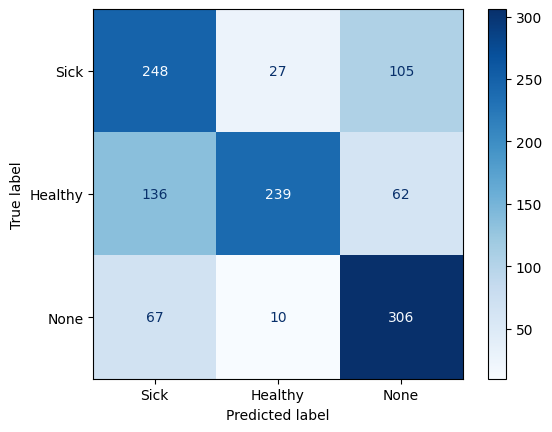

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sick', 'Healthy', 'None'])
disp.plot(cmap='Blues')